# Baseline results: 8 distortions vs models

In [41]:
import os
import json
import pandas as pd
from collections import defaultdict
baseline_dir = "cer_res_norm_capped/base_comparison"
DISTORTION_ORDER = [
    "clean", "fast", "reversed", "narrowband",
    "tone_vocoded", "noise_vocoded", "sinewave","glimpsed", "sculpted"
]

MODEL_ORDER = [
    "whspr-small", "owsm4", "owsm-ctc4",
    "wavlm-large", "wav2vec2-large-xlsr", "wav2vec2-base-lm"
]

def format_df(table):
    df = pd.DataFrame.from_dict(table, orient="index")
    df.index.name = "Distortion"
    df.columns.name = "Model"
    # Reorder index (rows) and columns
    df = df.reindex(index=DISTORTION_ORDER)
    df = df.reindex(columns=MODEL_ORDER)
    return df
def generate_baseline_tables_and_save_to_csv(metric="cer", input_path=baseline_dir, output_path="table_results/"):
    print(f"Processing {metric}")
    metric_table = defaultdict(dict)
    avg_metric_table = defaultdict(dict)
    med_metric_table = defaultdict(dict)

    for fname in os.listdir(input_path):
        if not fname.lower().endswith(".json"):
            continue
        base = fname.rsplit("_results_", 1)[0]
        if "_" not in base:
            continue
        model, distortion = base.split("_", 1)

        with open(os.path.join(input_path, fname), "r", encoding="utf-8") as f:
            data = json.load(f)

        overall_metric = data.get(f"overall_{metric}", None)

        # Try multiple possible average metric keys
        avg_metric = (
            data.get(f"avg_{metric}")
            or data.get(f"average_{metric}")
            or None
        )

        med_metric = data.get(f"median_{metric}", None)

        if overall_metric is not None:
            metric_table[distortion][model] = overall_metric
            avg_metric_table[distortion][model] = avg_metric
            med_metric_table[distortion][model] = med_metric

    df = format_df(metric_table)
    avg_df = format_df(avg_metric_table)
    med_df = format_df(med_metric_table)

    os.makedirs(output_path, exist_ok=True)
    df.to_csv(os.path.join(output_path, f"overall_{metric}_summary.csv"))
    avg_df.to_csv(os.path.join(output_path, f"average_{metric}_summary.csv"))
    med_df.to_csv(os.path.join(output_path, f"median_{metric}_summary.csv"))
    print(f"saved df")
    return df, avg_df, med_df


df, avg_df, md_df = generate_baseline_tables_and_save_to_csv("cer")
display(avg_df)

Processing cer
saved df


Model,whspr-small,owsm4,owsm-ctc4,wavlm-large,wav2vec2-large-xlsr,wav2vec2-base-lm
Distortion,,,,,,
clean,0.0343,0.0485,0.0293,0.0726,0.094435,0.0761
fast,0.6899,0.8729,0.8713,0.7533,0.668319,0.7486
reversed,0.5923,0.7499,0.6559,0.5183,0.585060,0.5869
narrowband,0.9711,0.9626,0.9656,0.9945,0.805347,0.9414
tone_vocoded,0.9221,0.8872,0.6260,0.4578,0.598760,0.4409
noise_vocoded,0.2449,0.4548,0.3673,0.3256,0.441298,0.4036
sinewave,0.3177,0.3315,0.3160,0.3153,0.475810,0.5381
glimpsed,0.4168,0.4118,0.3715,0.4829,0.527235,0.5291
sculpted,0.7173,0.8396,0.8849,0.7484,0.678085,0.6988


In [ ]:
# wav2vec2-large-xlsr missing avg table, because the entry is "average_cer" instead of "avg_cer"

## Merging overall, average, median CER

In [42]:
import pandas as pd

# Read in the three CSVs
overall = pd.read_csv("table_results/overall_cer_summary.csv")
avg = pd.read_csv("table_results/average_cer_summary.csv")
median = pd.read_csv("table_results/median_cer_summary.csv")

# Ensure they have the same structure and 'Distortion' column
assert all(overall.columns == avg.columns)
assert all(overall.columns == median.columns)

# Start with Distortion column
merged = pd.DataFrame()
merged['Distortion'] = overall['Distortion']

# Merge per model column
for col in overall.columns[1:]:
    merged[col] = [
        f"{o:.4f} | {a:.4f} | {m:.4f}"
        if pd.notna(o) and pd.notna(a) and pd.notna(m) else ""
        for o, a, m in zip(overall[col], avg[col], median[col])
    ]

# Save to CSV
merged.to_csv("table_results/combined_cer.csv", index=False)

print("Merged table saved as combined_cer.csv")
display(merged)

Merged table saved as combined_cer.csv


,Distortion,whspr-small,owsm4,owsm-ctc4,wavlm-large,wav2vec2-large-xlsr,wav2vec2-base-lm
0,clean,0.0321 | 0.0343 | 0.0000,0.0370 | 0.0485 | 0.0130,0.0249 | 0.0293 | 0.0042,0.0630 | 0.0726 | 0.0577,0.0945 | 0.0944 | 0.0744,0.0598 | 0.0761 | 0.0497
1,fast,0.9301 | 0.6899 | 0.6944,0.8944 | 0.8729 | 0.9245,0.9029 | 0.8713 | 0.9150,0.7512 | 0.7533 | 0.7590,0.6690 | 0.6683 | 0.6738,0.7446 | 0.7486 | 0.7500
2,reversed,1.0817 | 0.5923 | 0.5778,0.7465 | 0.7499 | 0.8261,0.6804 | 0.6559 | 0.6818,0.4885 | 0.5183 | 0.5102,0.5591 | 0.5851 | 0.5758,0.5560 | 0.5869 | 0.5824
3,narrowband,0.9801 | 0.9711 | 0.9785,0.9741 | 0.9626 | 0.9692,0.9701 | 0.9656 | 0.9700,0.9958 | 0.9945 | 1.0000,0.8266 | 0.8053 | 0.7925,0.9488 | 0.9414 | 0.9529
4,tone_vocoded,1.5661 | 0.9221 | 0.9697,0.9083 | 0.8872 | 0.9458,0.5656 | 0.6260 | 0.5847,0.4391 | 0.4578 | 0.4328,0.5977 | 0.5988 | 0.6087,0.4104 | 0.4409 | 0.4308
5,noise_vocoded,0.2078 | 0.2449 | 0.1863,0.3758 | 0.4548 | 0.3770,0.3057 | 0.3673 | 0.3103,0.2783 | 0.3256 | 0.2903,0.4247 | 0.4413 | 0.4372,0.3682 | 0.4036 | 0.3873
6,sinewave,0.3373 | 0.3177 | 0.2667,0.2804 | 0.3315 | 0.2723,0.2835 | 0.3160 | 0.2899,0.2763 | 0.3153 | 0.2837,0.4580 | 0.4758 | 0.4720,0.5172 | 0.5381 | 0.5437
7,glimpsed,0.4793 | 0.4168 | 0.3824,0.3667 | 0.4118 | 0.3571,0.3350 | 0.3715 | 0.3315,0.4605 | 0.4829 | 0.4762,0.5187 | 0.5272 | 0.5333,0.5067 | 0.5291 | 0.5317
8,sculpted,1.2702 | 0.7173 | 0.7049,0.8526 | 0.8396 | 0.8889,0.9038 | 0.8849 | 0.9412,0.7496 | 0.7484 | 0.7531,0.6743 | 0.6781 | 0.6812,0.6782 | 0.6988 | 0.6949


In [43]:
# merged cmer
import pandas as pd

# Read in the three CSVs
overall = pd.read_csv("table_results/overall_cmer_summary.csv")
avg = pd.read_csv("table_results/average_cmer_summary.csv")
median = pd.read_csv("table_results/median_cmer_summary.csv")

# Ensure they have the same structure and 'Distortion' column
assert all(overall.columns == avg.columns)
assert all(overall.columns == median.columns)

# Start with Distortion column
merged = pd.DataFrame()
merged['Distortion'] = overall['Distortion']

# Merge per model column
for col in overall.columns[1:]:
    merged[col] = [
        f"{o:.4f} | {a:.4f} | {m:.4f}"
        if pd.notna(o) and pd.notna(a) and pd.notna(m) else ""
        for o, a, m in zip(overall[col], avg[col], median[col])
    ]

# Save to CSV
merged.to_csv("table_results/combined_cmer.csv", index=False)

print("Merged table saved as combined_cmer.csv")
display(merged)

Merged table saved as combined_cmer.csv


,Distortion,whspr-small,owsm4,owsm-ctc4,wavlm-large,wav2vec2-large-xlsr,wav2vec2-base-lm
0,clean,0.0312 | 0.0330 | 0.0000,0.0353 | 0.0463 | 0.0129,0.0245 | 0.0283 | 0.0042,0.0617 | 0.0714 | 0.0568,0.0930 | 0.0926 | 0.0732,0.0582 | 0.0729 | 0.0490
1,fast,0.6421 | 0.6767 | 0.6800,0.8696 | 0.8712 | 0.9241,0.8807 | 0.8700 | 0.9141,0.7417 | 0.7523 | 0.7586,0.6568 | 0.6641 | 0.6704,0.7321 | 0.7467 | 0.7488
2,reversed,0.6145 | 0.5399 | 0.5161,0.7006 | 0.7333 | 0.8095,0.6522 | 0.6428 | 0.6605,0.4691 | 0.5058 | 0.4968,0.5119 | 0.5252 | 0.5319,0.5092 | 0.5378 | 0.5367
3,narrowband,0.9684 | 0.9706 | 0.9785,0.9591 | 0.9625 | 0.9691,0.9569 | 0.9654 | 0.9700,0.9878 | 0.9945 | 1.0000,0.7866 | 0.8016 | 0.7895,0.9363 | 0.9411 | 0.9527
4,tone_vocoded,0.6838 | 0.9116 | 0.9667,0.8079 | 0.8831 | 0.9444,0.5352 | 0.6144 | 0.5714,0.4311 | 0.4542 | 0.4269,0.5814 | 0.5864 | 0.5939,0.3949 | 0.4261 | 0.4167
5,noise_vocoded,0.1958 | 0.2302 | 0.1792,0.3496 | 0.4416 | 0.3594,0.2943 | 0.3595 | 0.3040,0.2710 | 0.3196 | 0.2875,0.4100 | 0.4263 | 0.4255,0.3506 | 0.3861 | 0.3711
6,sinewave,0.2947 | 0.2959 | 0.2513,0.2620 | 0.3150 | 0.2581,0.2712 | 0.3045 | 0.2791,0.2699 | 0.3107 | 0.2768,0.4435 | 0.4620 | 0.4609,0.5020 | 0.5279 | 0.5345
7,glimpsed,0.4014 | 0.3841 | 0.3577,0.3461 | 0.3987 | 0.3415,0.3226 | 0.3631 | 0.3200,0.4521 | 0.4789 | 0.4722,0.5012 | 0.5115 | 0.5214,0.4902 | 0.5159 | 0.5179
8,sculpted,0.6830 | 0.6557 | 0.6370,0.7895 | 0.8279 | 0.8832,0.8813 | 0.8831 | 0.9412,0.7372 | 0.7466 | 0.7525,0.6531 | 0.6637 | 0.6692,0.6560 | 0.6866 | 0.6860


In [48]:
import pandas as pd

df = pd.read_csv("table_results/combined_cmer.csv")
latex_table = []

for idx, row in df.iterrows():
    line = [row["Distortion"]]
    for col in df.columns[1:]:
        parts = [p.strip() for p in row[col].split("|")]
        line.append("\\makecell{" + " \\\\ ".join(parts) + "}")
        
    latex_table.append(" & ".join(line) + " \\\\")

print("\n\\hline\n".join(latex_table))


clean & \makecell{0.0312 \\ 0.0330 \\ 0.0000} & \makecell{0.0353 \\ 0.0463 \\ 0.0129} & \makecell{0.0245 \\ 0.0283 \\ 0.0042} & \makecell{0.0617 \\ 0.0714 \\ 0.0568} & \makecell{0.0930 \\ 0.0926 \\ 0.0732} & \makecell{0.0582 \\ 0.0729 \\ 0.0490} \\
\hline
fast & \makecell{0.6421 \\ 0.6767 \\ 0.6800} & \makecell{0.8696 \\ 0.8712 \\ 0.9241} & \makecell{0.8807 \\ 0.8700 \\ 0.9141} & \makecell{0.7417 \\ 0.7523 \\ 0.7586} & \makecell{0.6568 \\ 0.6641 \\ 0.6704} & \makecell{0.7321 \\ 0.7467 \\ 0.7488} \\
\hline
reversed & \makecell{0.6145 \\ 0.5399 \\ 0.5161} & \makecell{0.7006 \\ 0.7333 \\ 0.8095} & \makecell{0.6522 \\ 0.6428 \\ 0.6605} & \makecell{0.4691 \\ 0.5058 \\ 0.4968} & \makecell{0.5119 \\ 0.5252 \\ 0.5319} & \makecell{0.5092 \\ 0.5378 \\ 0.5367} \\
\hline
narrowband & \makecell{0.9684 \\ 0.9706 \\ 0.9785} & \makecell{0.9591 \\ 0.9625 \\ 0.9691} & \makecell{0.9569 \\ 0.9654 \\ 0.9700} & \makecell{0.9878 \\ 0.9945 \\ 1.0000} & \makecell{0.7866 \\ 0.8016 \\ 0.7895} & \makecell{0.9363 

## Plotting 8 baseline results

### Plotting CER results

In [5]:
table_path="table_results/"

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_metric_summary_table(
    csv_path,
    title=None,
    metric_name="CER",
    figsize=(12, 6),
    rotate_xlabels=True,
    save_path=None
):
    df = pd.read_csv(csv_path)

    # Reshape to long format
    df_melted = df.melt(id_vars="Distortion", var_name="Model", value_name=metric_name)

    # Initialize plot
    plt.figure(figsize=figsize)
    sns.barplot(
        data=df_melted,
        x="Distortion", y=metric_name, hue="Model",palette="Set2"
    )

    # Formatting
    plt.title(title or os.path.basename(csv_path).replace("_", " ").replace(".csv", "").title())
    plt.ylabel(metric_name)
    plt.xlabel("Distortion Type")
    if rotate_xlabels:
        plt.xticks(rotation=45, ha="right")

    # for y in [0.2, 0.4, 0.6, 0.8]:
    #     plt.axhline(y=y, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)

    # Or enable a full horizontal grid
    plt.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.6)
    
    # Legend positioning
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved plot to {save_path}")
    else:
        plt.show()


Saved plot to picture_results/Overall CER for 8 Baseline Distortions


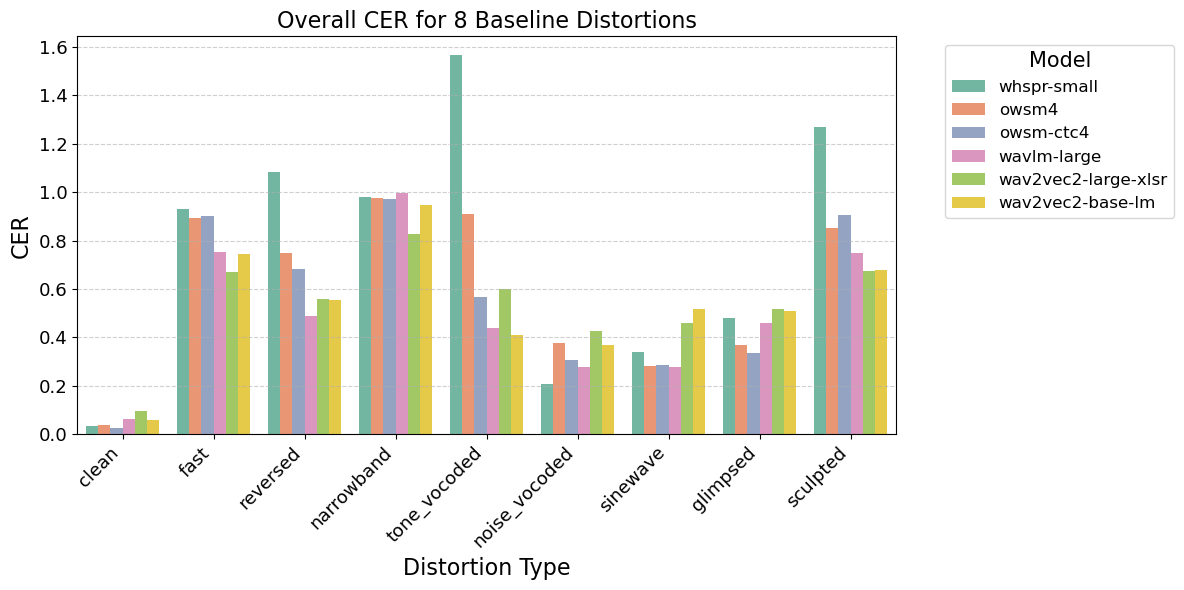

In [94]:
import os
metric_name="CER"
metric_type="Overall"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_summary_table(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Baseline Distortions",
    metric_name="CER",
    save_path=f"picture_results/{metric_type} {metric_name} for 8 Baseline Distortions"
)

Saved plot to picture_results/Average CER for 8 Baseline Distortions


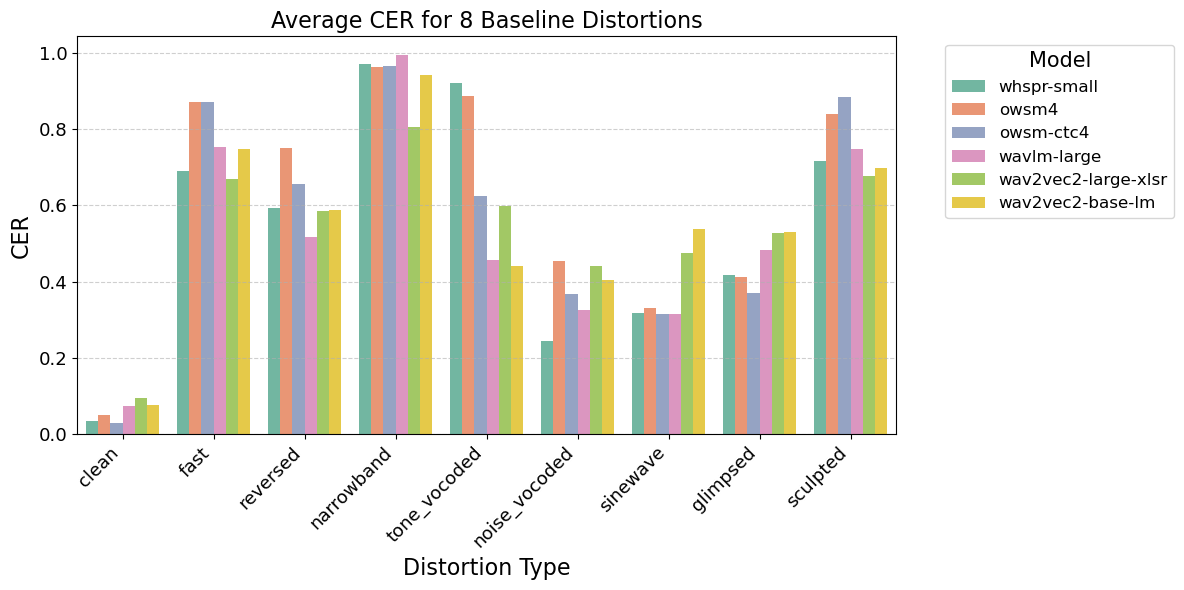

In [97]:
import os
path=os.path.join(table_path,"average_cer_summary.csv")
plot_metric_summary_table(
    csv_path=path,
    title="Average CER for 8 Baseline Distortions",
    metric_name="CER",
    save_path="picture_results/Average CER for 8 Baseline Distortions"
)

Saved plot to picture_results/Median CER for 8 Baseline Distortions


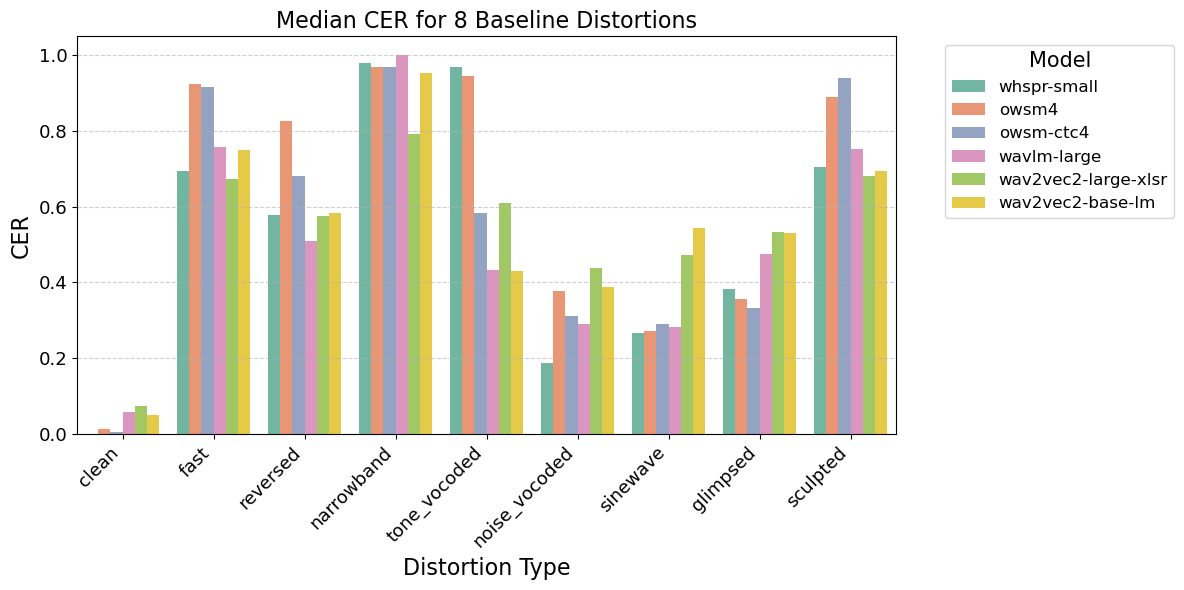

In [98]:
import os
path=os.path.join(table_path,"median_cer_summary.csv")
plot_metric_summary_table(
    csv_path=path,
    title="Median CER for 8 Baseline Distortions",
    metric_name="CER",
    save_path="picture_results/Median CER for 8 Baseline Distortions"
)

### Plotting CMER results

Saved plot to picture_results/Overall CMER for 8 Baseline Distortions


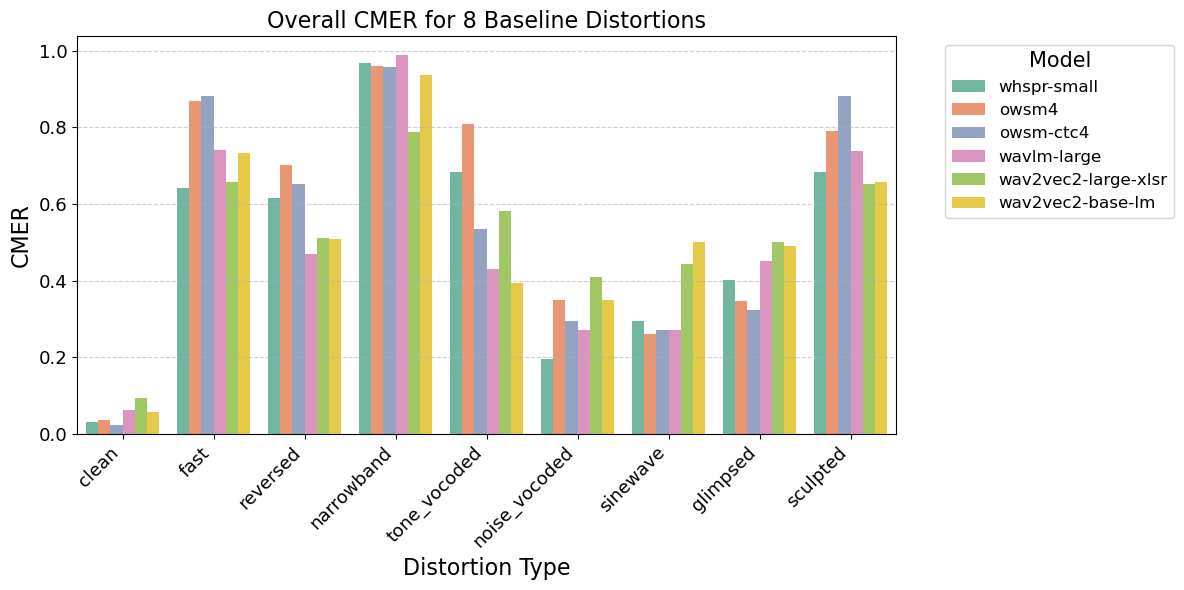

In [99]:
import os
metric_name="CMER"
metric_type="Overall"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_summary_table(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Baseline Distortions",
    metric_name=metric_name,
    save_path=f"picture_results/{metric_type} {metric_name} for 8 Baseline Distortions"
)

Saved plot to picture_results/Average CMER for 8 Baseline Distortions


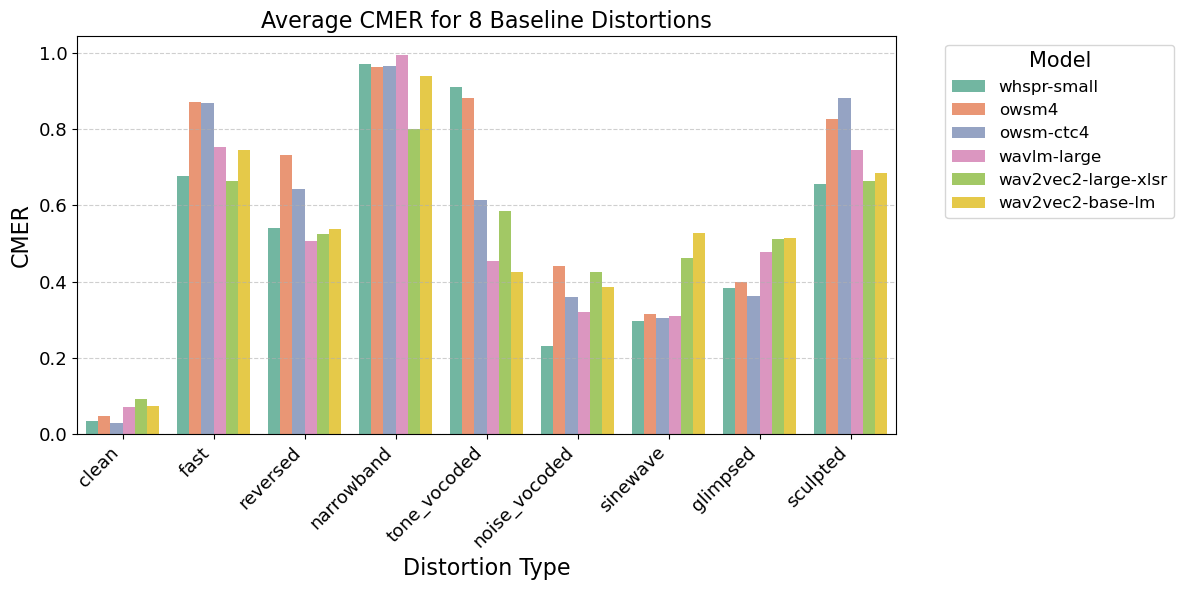

In [100]:
import os
metric_name="CMER"
metric_type="Average"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_summary_table(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Baseline Distortions",
    metric_name=metric_name,
    save_path=f"picture_results/{metric_type} {metric_name} for 8 Baseline Distortions"
)

Saved plot to picture_results/Median CMER for 8 Baseline Distortions


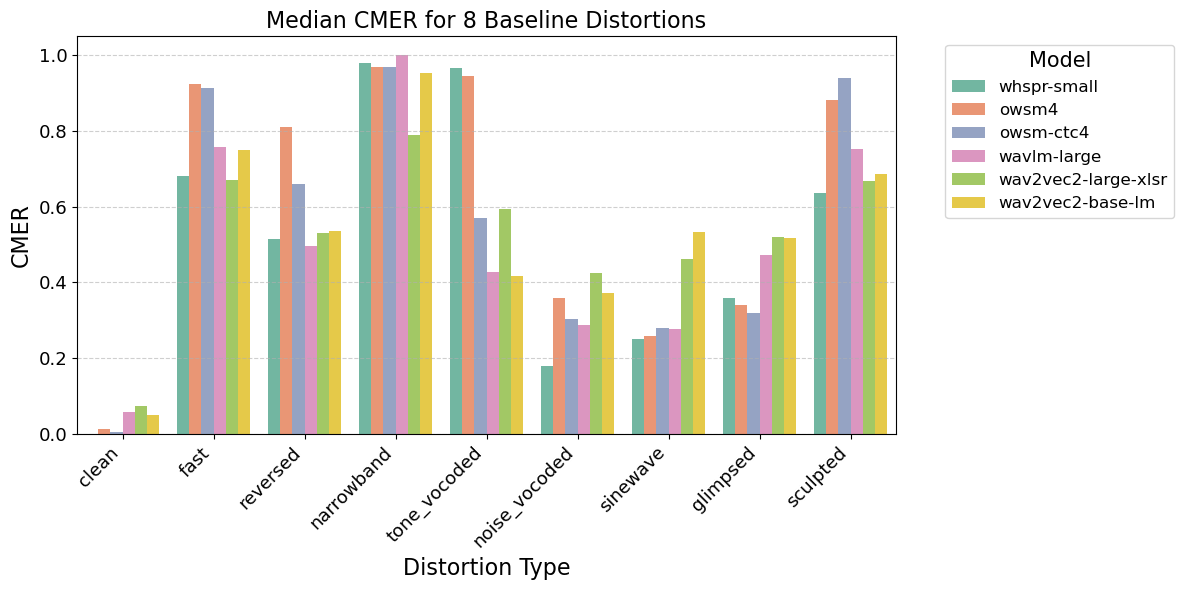

In [101]:
import os
metric_name="CMER"
metric_type="Median"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_summary_table(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Baseline Distortions",
    metric_name=metric_name,
    save_path=f"picture_results/{metric_type} {metric_name} for 8 Baseline Distortions"
)

## Boxplot of models

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
def plot_metric_boxplot(
    csv_path,
    title=None,
    metric_name="CER",
    figsize=(12, 6),
    rotate_xlabels=False,
    save_path=None
):
    # Load CSV
    df = pd.read_csv(csv_path)

    # Melt to long form
    df_melted = df.melt(
        id_vars=["Distortion"],
        var_name="Model",
        value_name=metric_name
    )

    # Sort distortions by median metric value
    order = (
        df_melted.groupby("Distortion")[metric_name]
        .median()
        .sort_values()
        .index
    )

    plt.figure(figsize=figsize)
    plt.rcParams.update({
        "axes.titlesize": 16,      # plot title
        "axes.labelsize": 16,      # x/y axis labels
        "xtick.labelsize": 13,     # x-axis tick labels
        "ytick.labelsize": 13,     # y-axis tick labels
        "legend.fontsize": 12,     # legend text
        "legend.title_fontsize": 15 # legend title
    })
    # Boxplot (transparent fill)
    sns.boxplot(
        data=df_melted,
        x="Distortion",
        y=metric_name,
        order=order,
        showcaps=True,
        boxprops={'facecolor': 'None', 'edgecolor': 'black'},
        medianprops={'color': 'red'},
        whiskerprops={'linewidth': 1.2}
    )

    # Dots for models
    sns.stripplot(
        data=df_melted,
        x="Distortion",
        y=metric_name,
        hue="Model",
        order=order,
        dodge=True,
        palette="Set2",
        size=5
    )
    plt.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.6)
    if rotate_xlabels:
        plt.xticks(rotation=45, ha="right",fontsize=13)
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.legend(title="Model", loc='upper left',frameon=True)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()


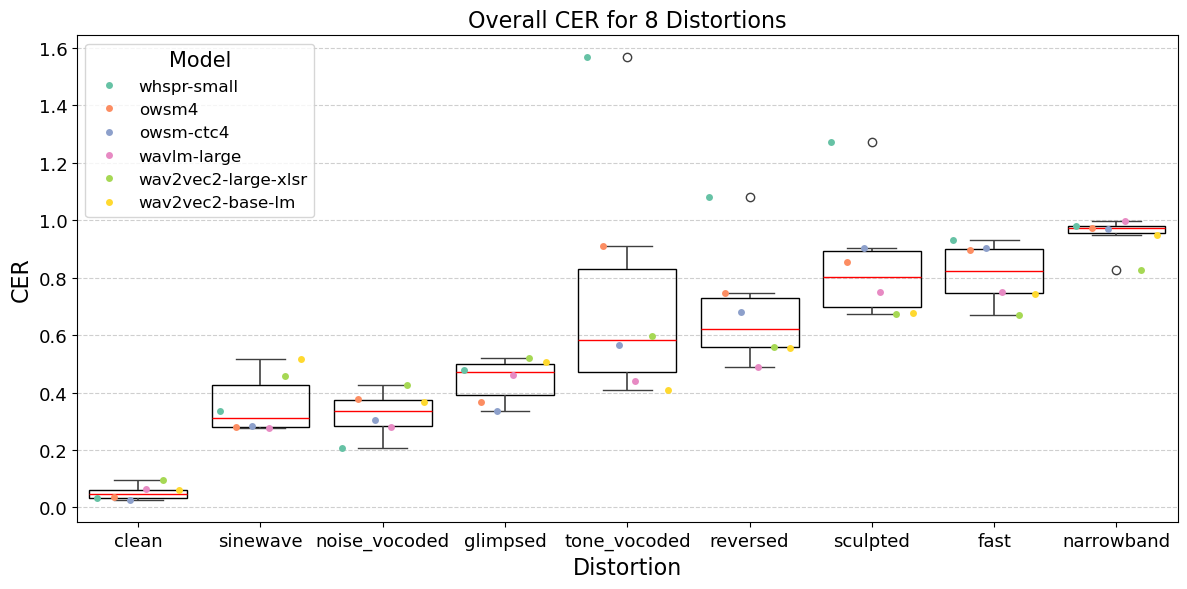

In [52]:
metric_name="CER"
metric_type="Overall"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_boxplot(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Distortions",
    metric_name=metric_name,
    save_path=f"picture_results/{metric_type} {metric_name} Boxplot"
)


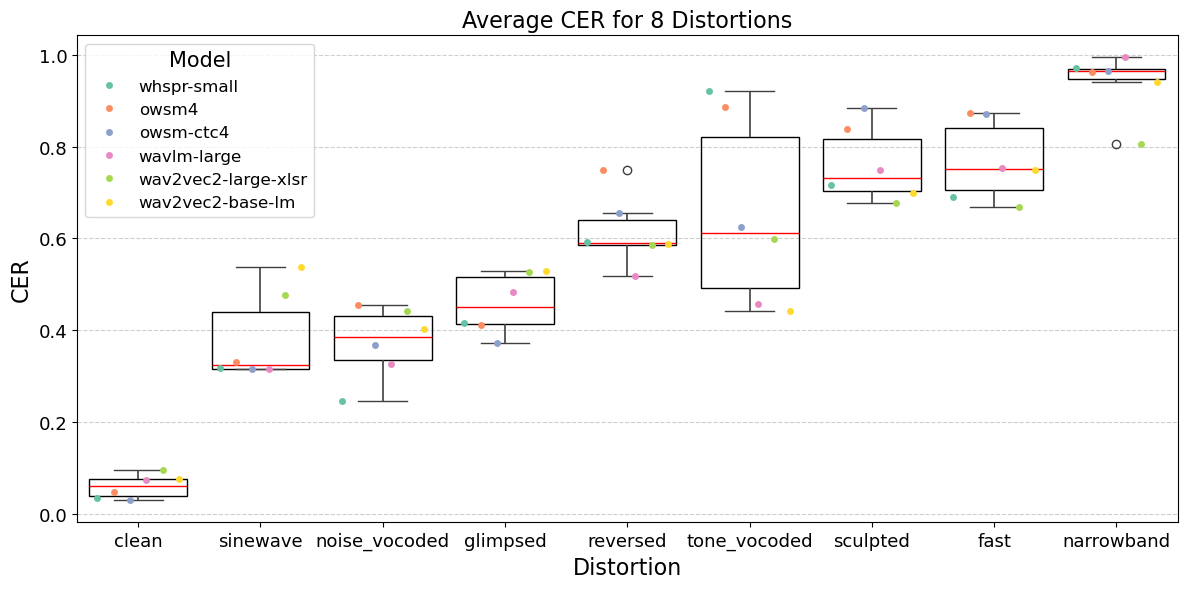

In [53]:
metric_name="CER"
metric_type="Average"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_boxplot(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Distortions",
    metric_name=metric_name,
    save_path=f"picture_results/{metric_type} {metric_name} Boxplot"
)

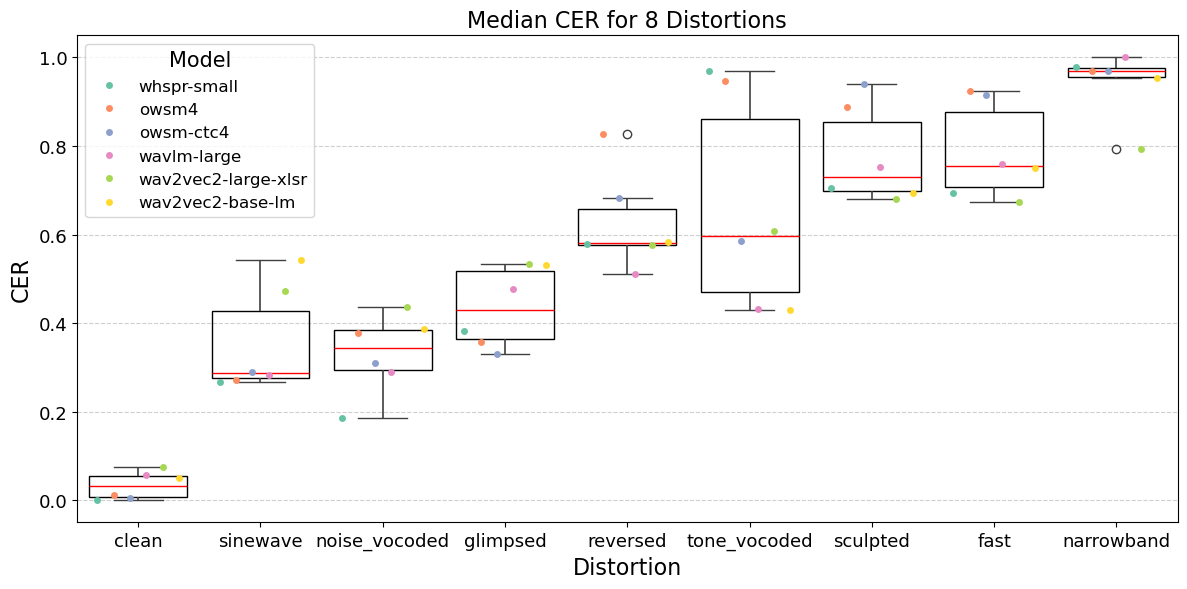

In [54]:
metric_name="CER"
metric_type="Median"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_boxplot(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Distortions",
    metric_name=metric_name,
    save_path=f"picture_results/{metric_type} {metric_name} Boxplot"
)

### Boxplot CMER

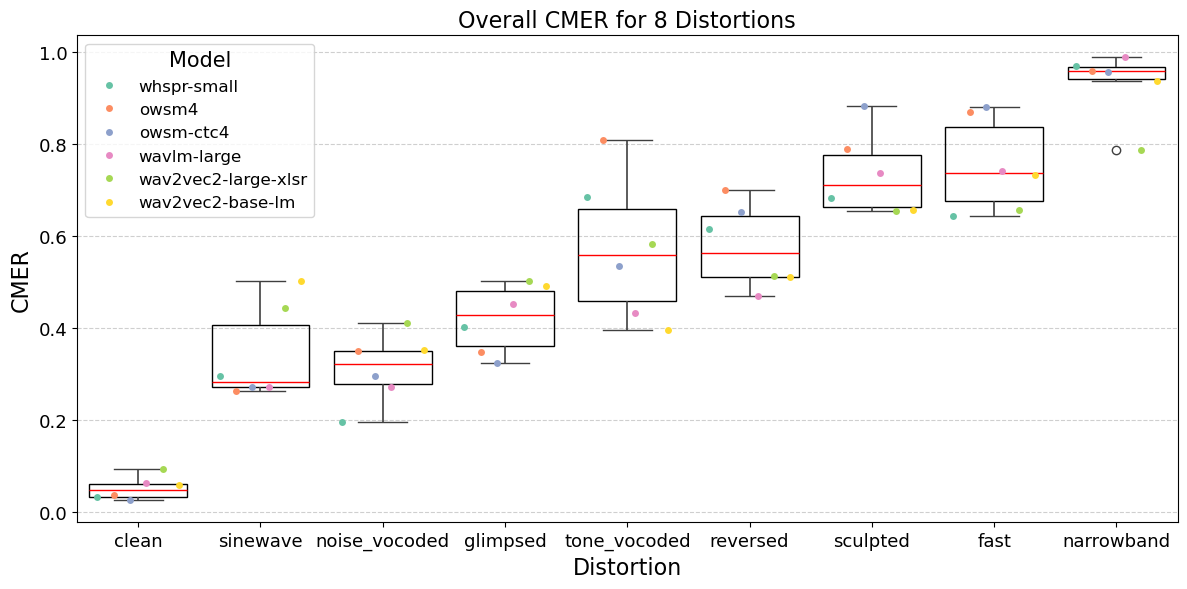

In [55]:
metric_name="CMER"
metric_type="Overall"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_boxplot(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Distortions",
    metric_name=metric_name,
    save_path=f"picture_results/{metric_type} {metric_name} Boxplot"
)

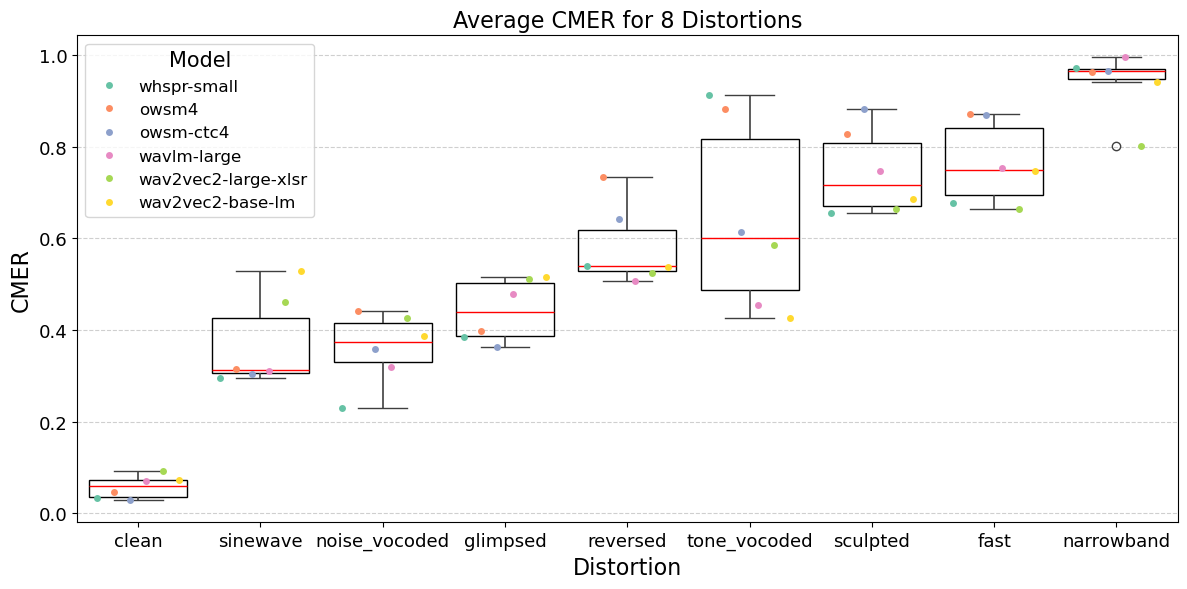

In [56]:
metric_name="CMER"
metric_type="Average"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_boxplot(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Distortions",
    metric_name=metric_name,
    save_path=f"picture_results/{metric_type} {metric_name} Boxplot"
)

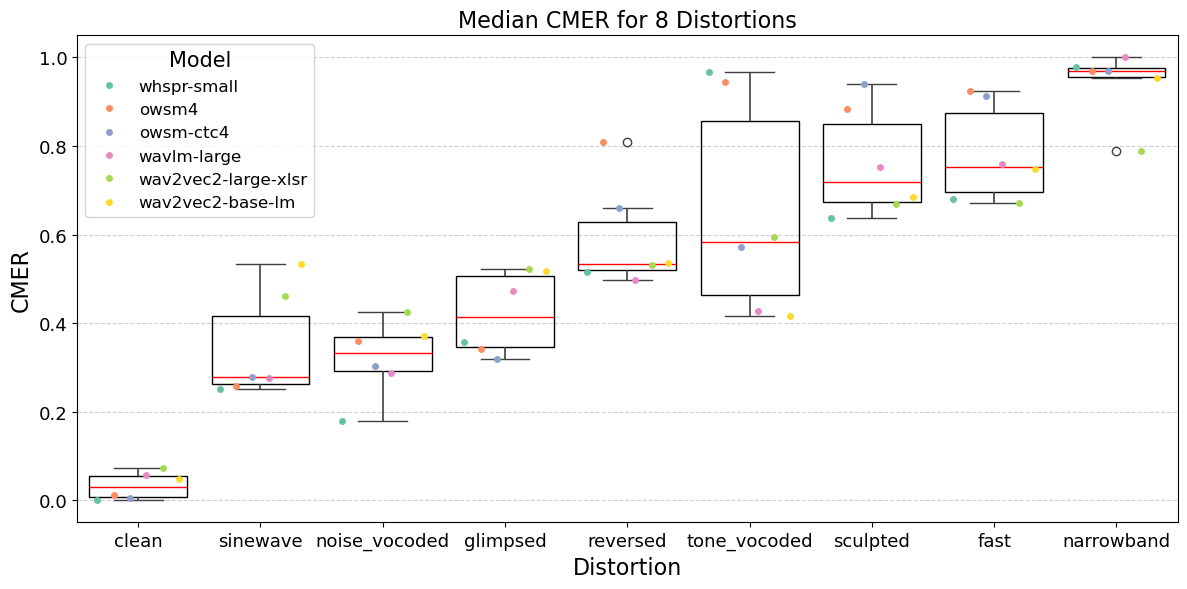

In [57]:
metric_name="CMER"
metric_type="Median"
path=os.path.join(table_path,f"{metric_type}_{metric_name.lower()}_summary.csv")
plot_metric_boxplot(
    csv_path=path,
    title=f"{metric_type} {metric_name} for 8 Distortions",
    metric_name=metric_name,
    save_path=f"picture_results/{metric_type} {metric_name} Boxplot"
)

# Adjusted distortion levels tables

In [27]:
# reads all files containing fast in the adjusted distorted folder
import re
import os
import json
import pandas as pd
from collections import defaultdict
adjusted_dir="cer_res_norm_capped/adjusted_distortion_results"
narrowband_condition_order=["mid_only_1_3","mid_only_2_3","mid_only_1.0","low_mid_1_3","high_mid_1_3","low_high_1_3","all_bands_1_3"]
fast_condition_order=["0.5","1.5","2.5"]
reversed_condition_order=["20ms", "31ms","40ms","50ms","62ms","80ms"]
MODEL_ORDER = [
    "whspr-small", "owsm4", "owsm-ctc4",
    "wavlm-large", "wav2vec2-large-xlsr", "wav2vec2-base-lm"
]
def generate_adjusted_tables_and_save_to_csv(
    condition,
    metric="cer",
    input_path=adjusted_dir,
    output_path="table_results"
    ):
    metric_table = defaultdict(dict)
    avg_metric_table = defaultdict(dict)
    med_metric_table = defaultdict(dict)

    # Choose ordering
    if condition == "narrowband":
        condition_order = narrowband_condition_order
    elif condition == "fast":
        condition_order = fast_condition_order
    elif condition == "reversed":
        condition_order = reversed_condition_order
    else:
        raise ValueError(f"Unknown condition: {condition}")

    # Regex pattern to extract model, distortion, and level
    pattern = re.compile(r"^(?P<model>.+?)_(?P<distortion>{})_(?P<level>.+?)_results_cer\.json$".format(condition))

    for fname in os.listdir(input_path):
        if condition not in fname.lower():
            continue
        if "ft" in fname.lower():
            continue
        match = pattern.match(fname)
        if not match:
            print(f"Skipping: {fname}")
            continue

        model = match.group("model")
        level = match.group("level")
        # print("model:", model, "| level:", level)

        with open(os.path.join(input_path, fname), "r", encoding="utf-8") as f:
            data = json.load(f)

        overall_metric = data.get(f"overall_{metric}", None)
        avg_metric = data.get(f"avg_{metric}", None)
        med_metric = data.get(f"median_{metric}", None)

        if overall_metric is not None:
            metric_table[level][model] = overall_metric
            avg_metric_table[level][model] = avg_metric
            med_metric_table[level][model] = med_metric

    def format_df(table):
        df = pd.DataFrame.from_dict(table, orient="index")
        df.index.name = "Condition"
        df.columns.name = "Model"
        df=df[MODEL_ORDER]
        return df.reindex(condition_order)
    def inject_clean_into_fast(fast_df, clean_csv_path, metric="CER"):
        # Load baseline clean results
        clean_df = pd.read_csv(clean_csv_path, index_col=0)
        
        # Extract the clean row
        clean_row = clean_df.loc["clean"]

        # Reindex columns to match fast_df ordering
        clean_row = clean_row.reindex(fast_df.columns)

        # Insert into FAST dataframe with index "1.0"
        fast_df.loc["1.0"] = clean_row

        # Re-sort by numeric order of conditions
        fast_df.index = fast_df.index.astype(float)
        fast_df = fast_df.sort_index()

        return fast_df

    df = format_df(metric_table)
    avg_df = format_df(avg_metric_table)
    med_df = format_df(med_metric_table)
    if condition=="fast":
        df  = inject_clean_into_fast(df,  os.path.join(output_path, f"overall_{metric}_summary.csv"), metric)
        avg_df = inject_clean_into_fast(avg_df, os.path.join(output_path, f"average_{metric}_summary.csv"), metric)
        med_df = inject_clean_into_fast(med_df, os.path.join(output_path, f"median_{metric}_summary.csv"), metric)

    print(condition)
    os.makedirs(output_path, exist_ok=True)
    df.to_csv(os.path.join(output_path, f"{condition}_overall_{metric}_summary.csv"))
    avg_df.to_csv(os.path.join(output_path, f"{condition}_average_{metric}_summary.csv"))
    med_df.to_csv(os.path.join(output_path, f"{condition}_median_{metric}_summary.csv"))

    print(f"Saved {condition} {metric} CSV tables to {output_path}")
    return df, avg_df, med_df
# df,_,md=generate_adjusted_tables_and_save_to_csv("reversed", "cmer")
# display(md)

In [28]:
df,_,_=generate_adjusted_tables_and_save_to_csv("fast", "cer")
display(_)

fast
Saved fast cer CSV tables to table_results


C:\Users\28177\AppData\Local\Temp\ipykernel_19072\1773854750.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fast_df.loc["1.0"] = clean_row


Model,whspr-small,owsm4,owsm-ctc4,wavlm-large,wav2vec2-large-xlsr,wav2vec2-base-lm
Condition,,,,,,
0.5,0.0150,0.064516,0.0301,0.106400,0.1250,0.2500
1.0,0.0000,0.012953,0.0042,0.057692,0.0744,0.0497
1.5,0.1717,0.232759,0.2336,0.383600,0.3115,0.5625
2.5,0.7143,0.927536,0.9177,0.761400,0.6752,0.7647


In [7]:
df,_,_=generate_adjusted_tables_and_save_to_csv("narrowband", "cmer")
display(df)

Skipping: wav2vec2-large-xlsr_narrowband_cer_1e-04_narrowband_all_bands_1_3_results.json
Skipping: wav2vec2-large-xlsr_narrowband_cer_1e-04_narrowband_high_mid_1_3_results.json
Skipping: wav2vec2-large-xlsr_narrowband_cer_1e-04_narrowband_low_high_1_3_results.json
Skipping: wav2vec2-large-xlsr_narrowband_cer_1e-04_narrowband_mid_only_1.0_results.json
Skipping: wav2vec2-large-xlsr_narrowband_cer_1e-04_narrowband_mid_only_2_3_results.json
narrowband
Saved narrowband cmer CSV tables to table_results


Model,owsm-ctc4,owsm4,wav2vec2-base-lm,wav2vec2-large-xlsr,wavlm-large,whspr-small
Condition,,,,,,
mid_only_1_3,0.957359,0.806175,0.929668,0.788428,0.987827,0.968411
mid_only_2_3,0.953167,0.518262,0.750874,0.680090,0.656962,0.725076
mid_only_1.0,0.954364,0.258390,0.606321,0.523686,0.334177,0.312650
low_mid_1_3,0.970627,0.906322,0.725000,0.640103,0.695265,0.860011
high_mid_1_3,0.977370,0.856096,0.792878,0.709031,0.801109,0.757856
low_high_1_3,0.971810,0.777425,0.771289,0.649513,0.906949,0.968247
all_bands_1_3,0.580693,0.657743,0.526947,0.492269,0.302681,0.666673


## Plotting adjusted FAST and REVERSED

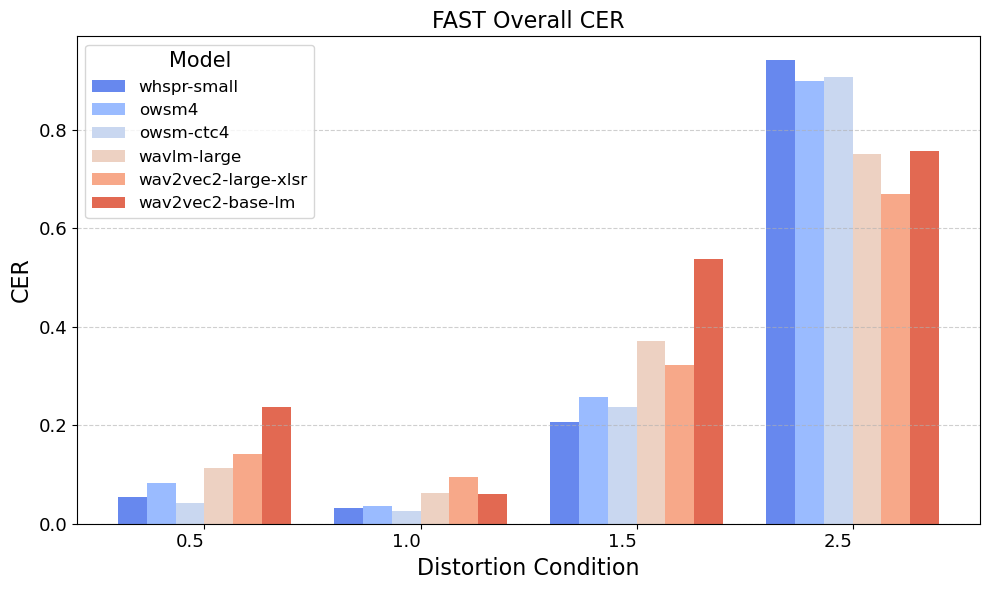

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
MODEL_ORDER = [
    "whspr-small", "owsm4", "owsm-ctc4",
    "wavlm-large", "wav2vec2-large-xlsr", "wav2vec2-base-lm"
]
import seaborn as sns
plt.rcParams.update({
    "axes.titlesize": 16,      # plot title
    "axes.labelsize": 16,      # x/y axis labels
    "xtick.labelsize": 13,     # x-axis tick labels
    "ytick.labelsize": 13,     # y-axis tick labels
    "legend.fontsize": 12,     # legend text
    "legend.title_fontsize": 15 # legend title
})

def plot_bar_from_csv(csv_path, palette="coolwarm"):
    # Extract parts from filename
    fname = os.path.basename(csv_path)
    parts = fname.replace(".csv", "").split("_")

    if len(parts) < 4:
        raise ValueError("Unexpected filename format. Expected pattern: <condition>_<avg/overall>_<metric>_summary.csv")

    condition = parts[0].capitalize()
    metric = parts[2].upper()
    summary_type = parts[1].capitalize()

    # Load the CSV
    df = pd.read_csv(csv_path, index_col=0)

    # Reorder models according to MODEL_ORDER (skip missing ones)
    models = [m for m in MODEL_ORDER if m in df.columns]
    distortions = df.index.tolist()

    num_models = len(models)
    x = np.arange(len(distortions))
    bar_width = 0.8 / num_models

    # get colors from seaborn palette
    colors = sns.color_palette(palette, num_models)

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (model, color) in enumerate(zip(models, colors)):
        ax.bar(
            x + i * bar_width,
            df[model],
            width=bar_width,
            label=model,
            color=color
        )

    ax.set_xticks(x + (num_models - 1) * bar_width / 2)
    ax.set_xticklabels(distortions, ha='right')

    ax.set_ylabel(f"{metric}")
    ax.set_xlabel("Distortion Condition")
    title = f"{condition.upper()} {summary_type} {metric}"
    ax.set_title(title)
    ax.legend(title="Model")
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.6)
    outpath = "picture_results/adjusted_distortion_picture_results"
    os.makedirs(outpath, exist_ok=True)
    plt.savefig(os.path.join(outpath, f"{title}.png"))
    plt.show()



plot_bar_from_csv("table_results/fast_overall_cer_summary.csv")

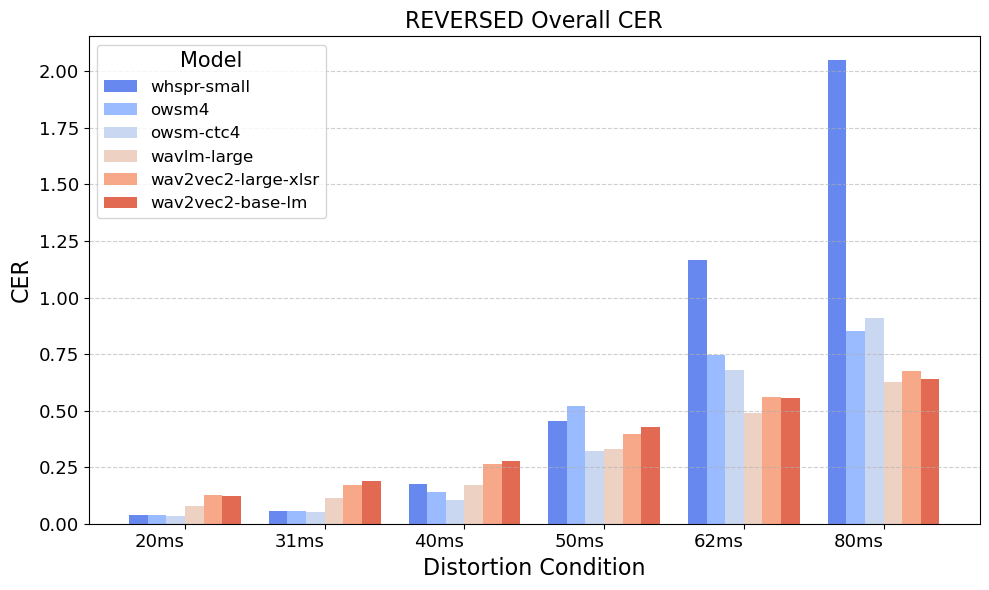

In [34]:
plot_bar_from_csv("table_results/reversed_overall_cer_summary.csv")

## Plotting adjusted NARROWBAND

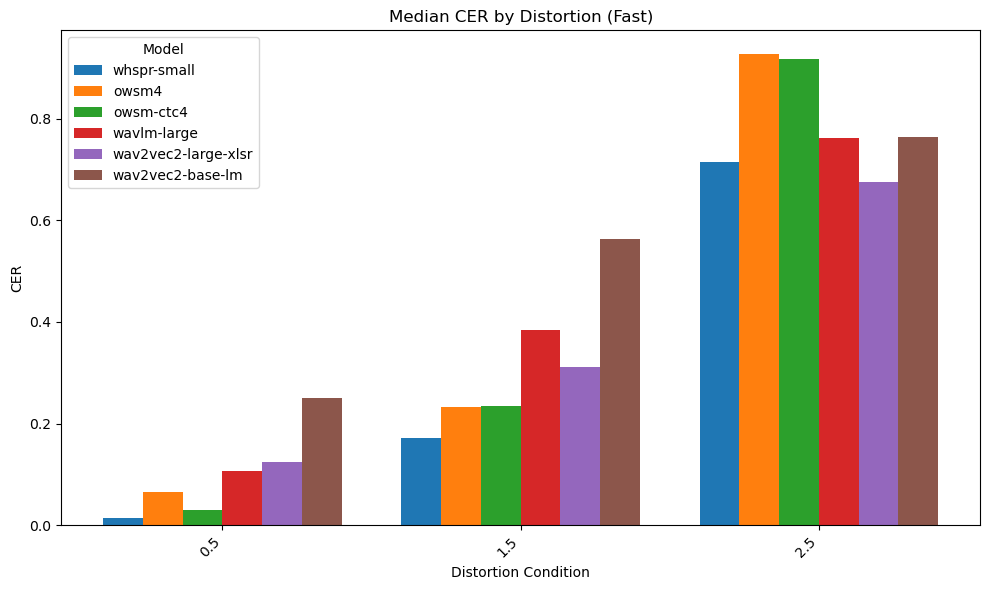

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_narrowband_comparison(
    csv_path,
    mode="bandwidth",  # "bandwidth" or "band_combination"
    title=None,
    metric_name="CMER",
    figsize=(12, 6),
    rotate_xlabels=False,
    save_path=None
):

    df = pd.read_csv(csv_path, index_col=0)

    if mode == "bandwidth":
        # select only mid_only conditions
        df_plot = df[df.index.str.startswith("mid_only")].copy()
        df_plot = df_plot.sort_index()  # maintain order
        df_melted = df_plot.reset_index().melt(
            id_vars="Condition", var_name="Model", value_name=metric_name
        )
        x_var = "Condition"
        plot_title = title or f"{metric_name} by Band Width"

    elif mode == "band_combination":
        # map each condition to a readable band combination name
        band_map = {
            "mid_only_1_3": "mid",
            "low_mid_1_3": "low+mid",
            "high_mid_1_3": "high+mid",
            "low_high_1_3": "low+high",
            "all_bands_1_3": "low+mid+high"
        }
        df_plot = df.copy()
        df_plot["Band Combination"] = df_plot.index.map(band_map)
        df_melted = df_plot.reset_index().melt(
            id_vars=["Condition","Band Combination"], var_name="Model", value_name=metric_name
        )
        x_var = "Band Combination"
        plot_title = title or f"{metric_name} by Band Combination"

    else:
        raise ValueError("mode must be 'bandwidth' or 'band_combination'")

    plt.figure(figsize=figsize)
    sns.barplot(data=df_melted, x=x_var, y=metric_name, hue="Model", palette="coolwarm")
    plt.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.6)
    plt.title(plot_title)
    plt.ylabel(metric_name)
    plt.xlabel(x_var.replace("_"," ").title())
    if rotate_xlabels:
        plt.xticks(rotation=45, ha="right")

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved plot to {save_path}")
    else:
        plt.show()


Saved plot to picture_results/adjusted_distortion_picture_results/Narrowband Overall CER by Bandwidth.png
Saved plot to picture_results/adjusted_distortion_picture_results/Narrowband Overall CER by Band_combination.png
Saved plot to picture_results/adjusted_distortion_picture_results/Narrowband Average CER by Bandwidth.png
Saved plot to picture_results/adjusted_distortion_picture_results/Narrowband Average CER by Band_combination.png
Saved plot to picture_results/adjusted_distortion_picture_results/Narrowband Median CER by Bandwidth.png
Saved plot to picture_results/adjusted_distortion_picture_results/Narrowband Median CER by Band_combination.png
Saved plot to picture_results/adjusted_distortion_picture_results/Narrowband Overall CMER by Bandwidth.png
Saved plot to picture_results/adjusted_distortion_picture_results/Narrowband Overall CMER by Band_combination.png
Saved plot to picture_results/adjusted_distortion_picture_results/Narrowband Average CMER by Bandwidth.png
Saved plot to pic

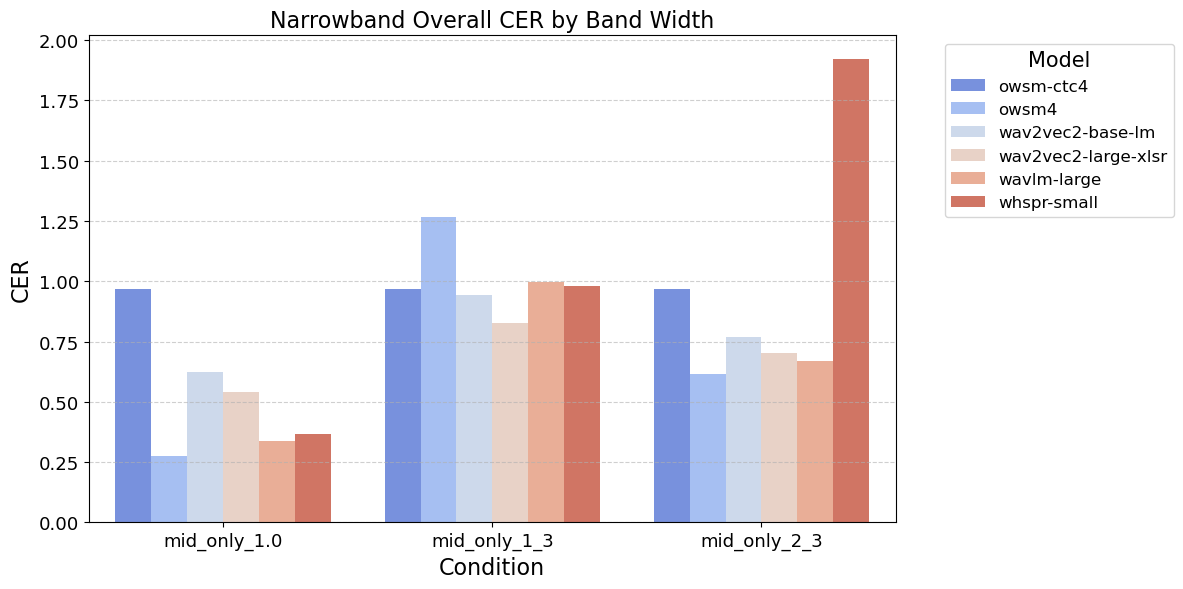

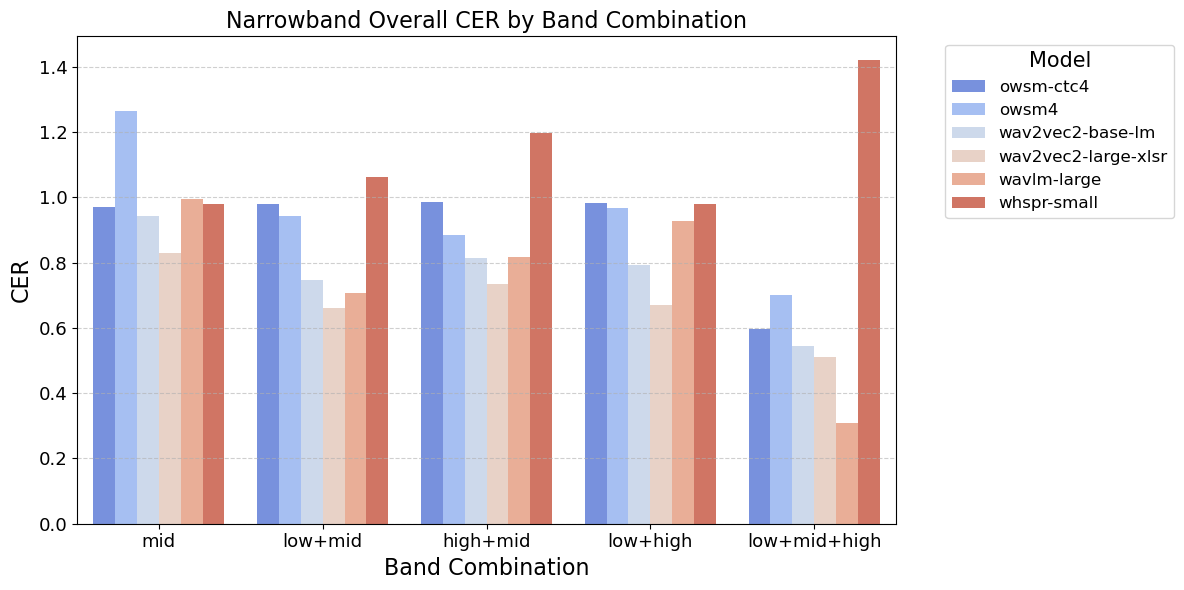

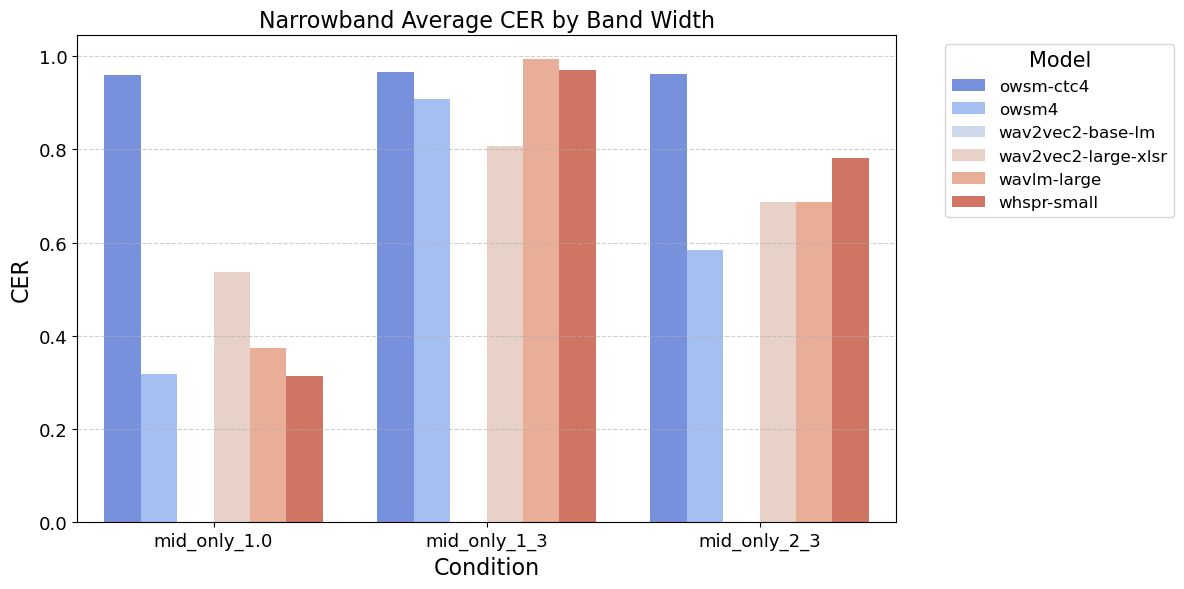

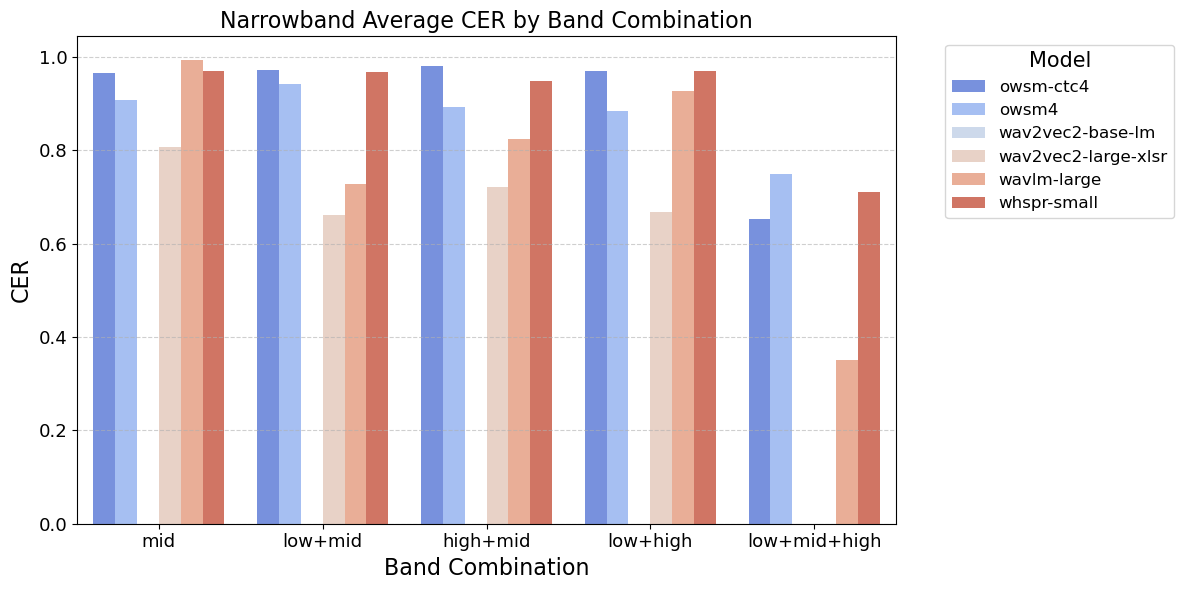

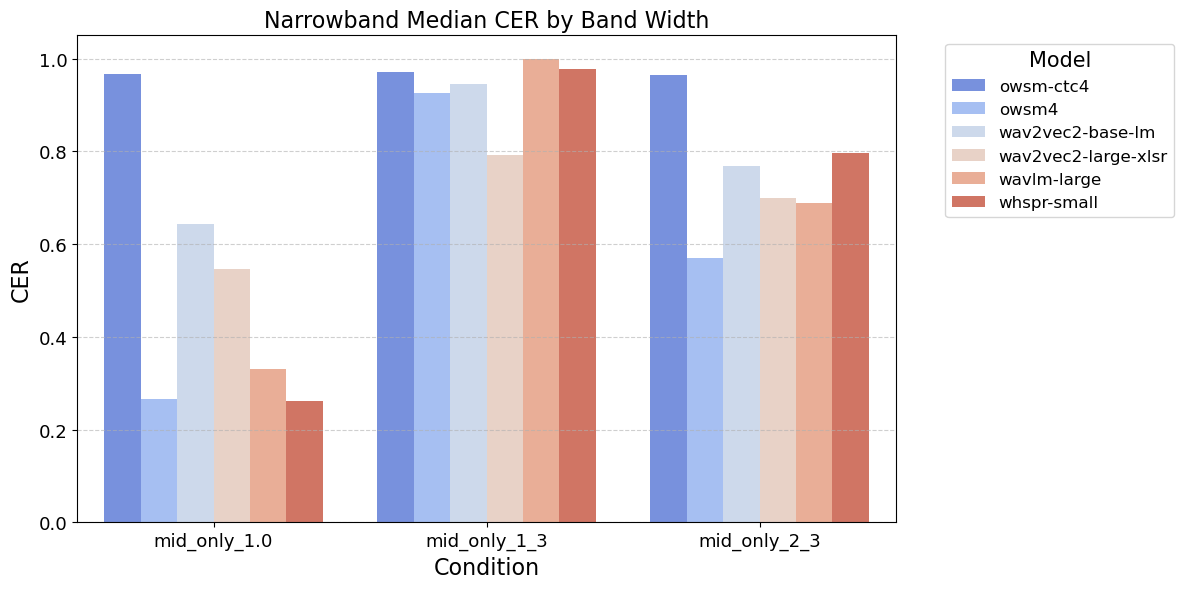

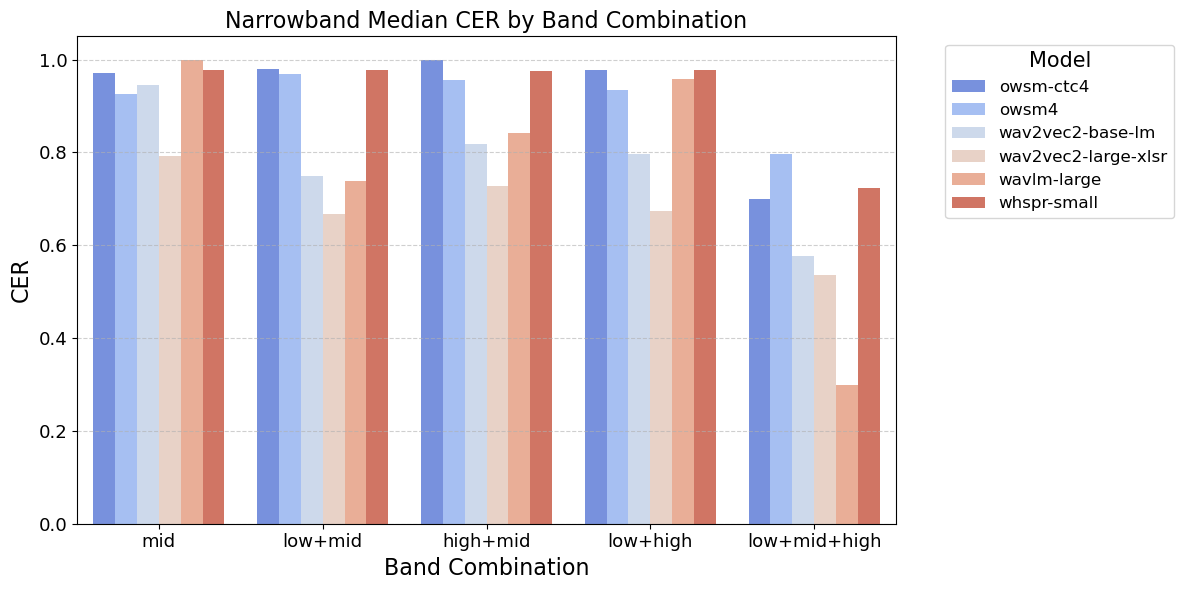

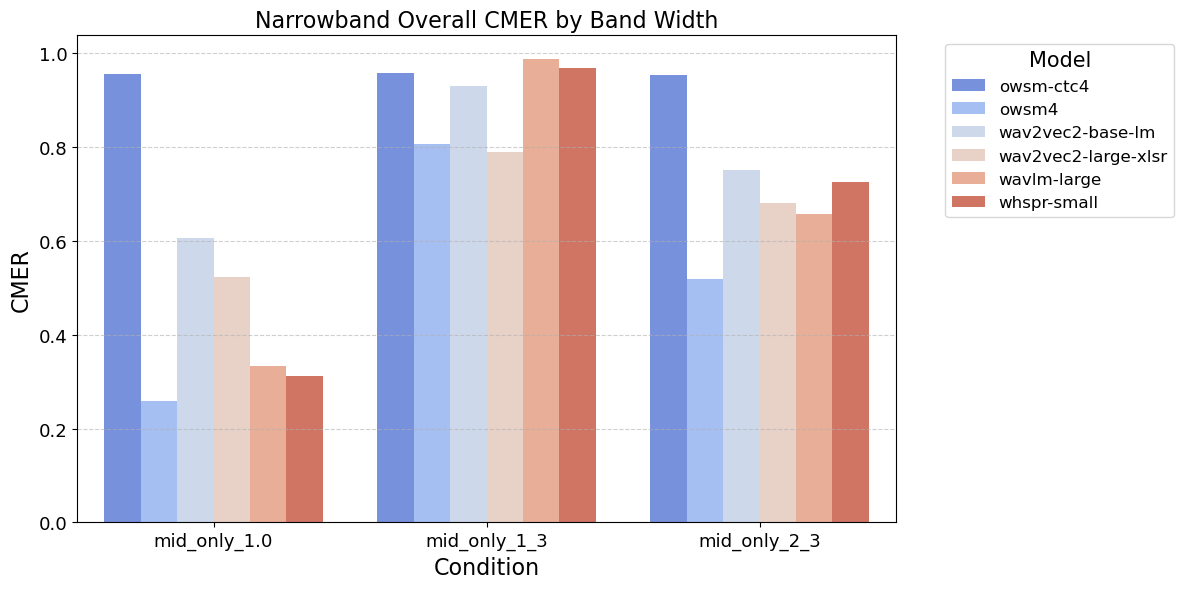

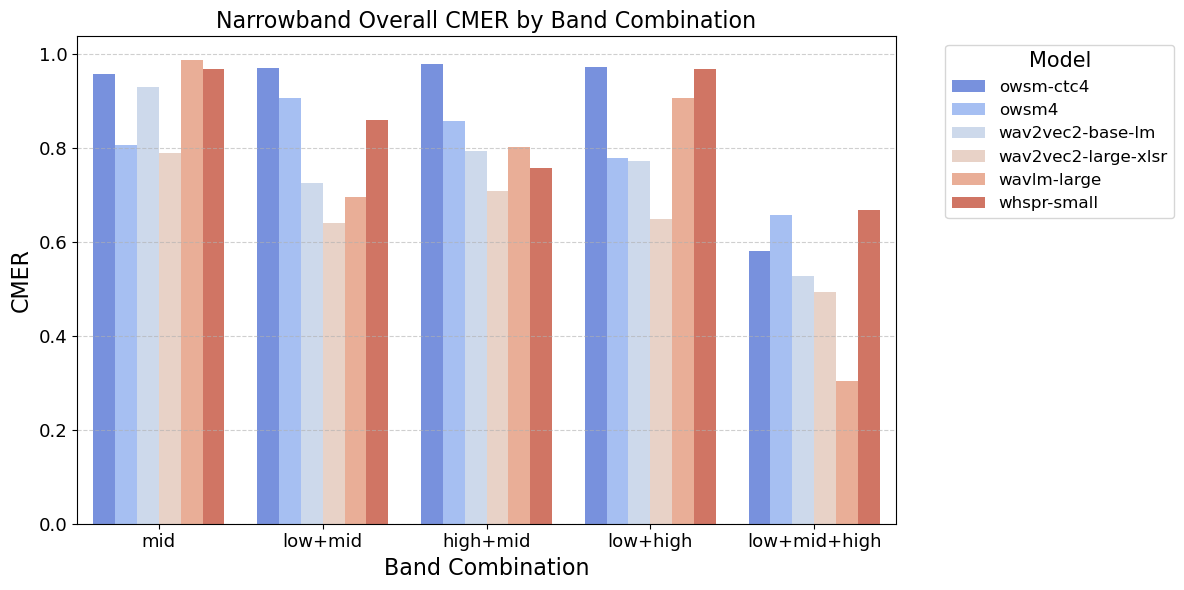

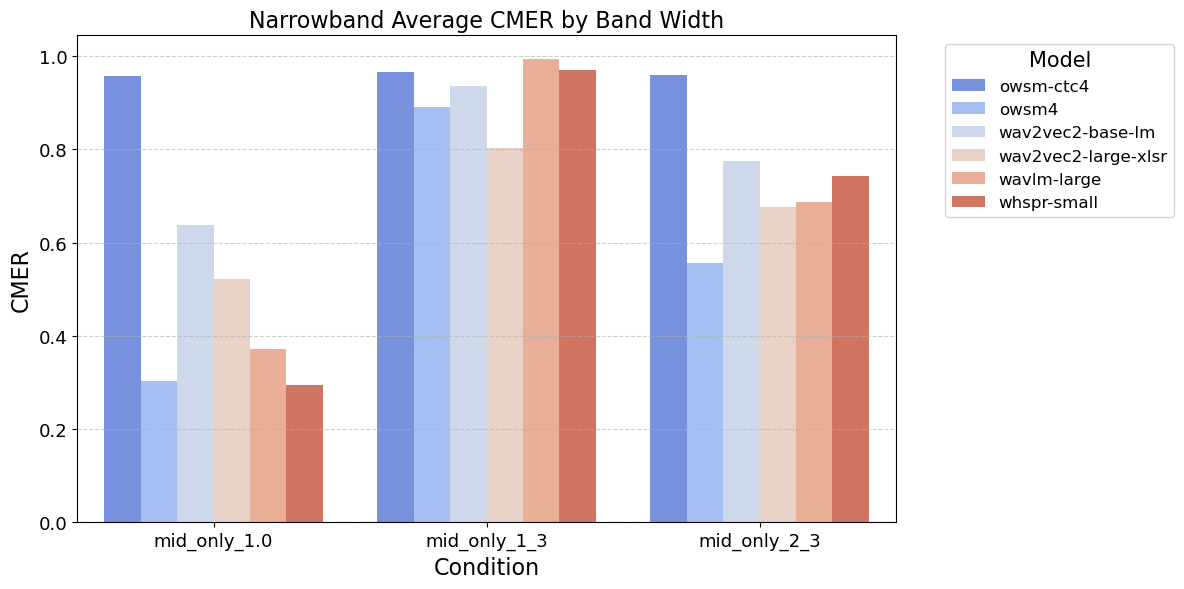

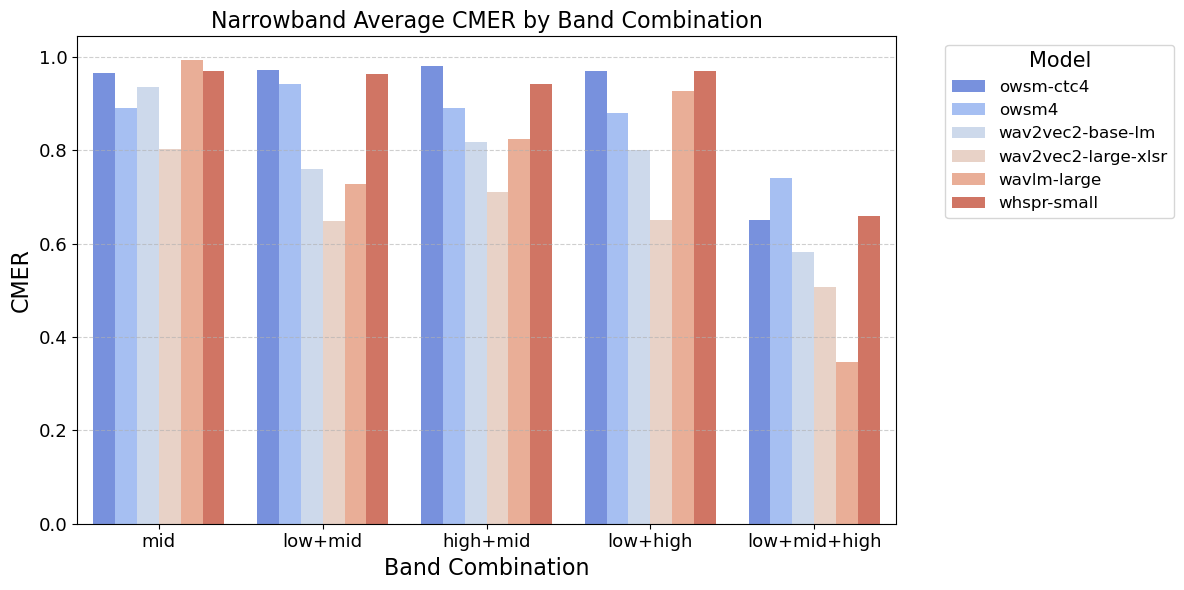

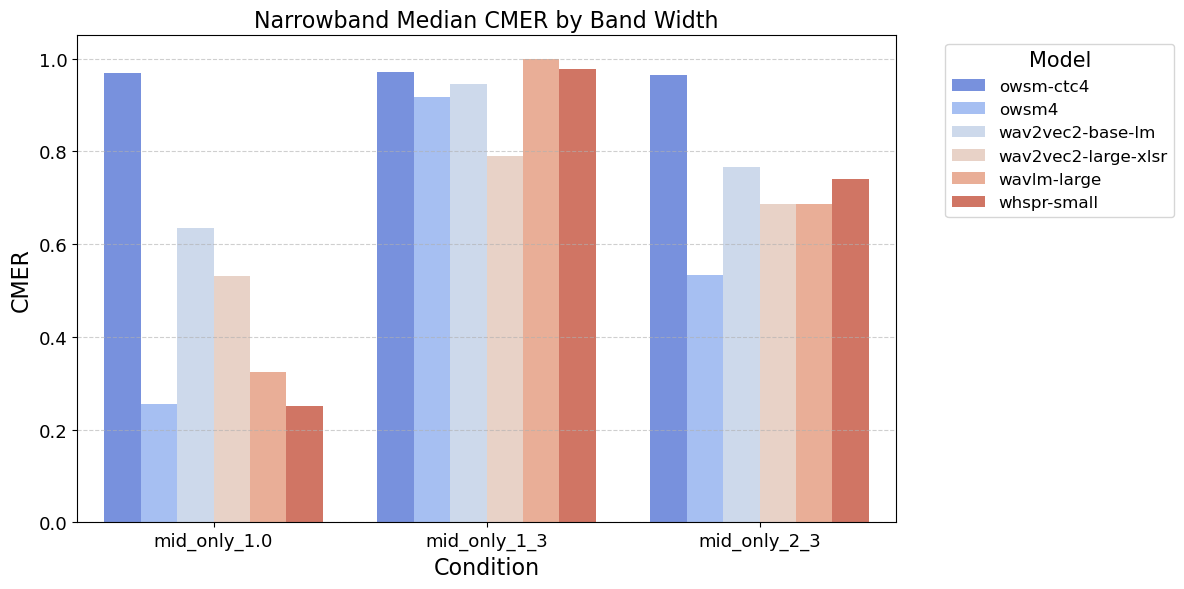

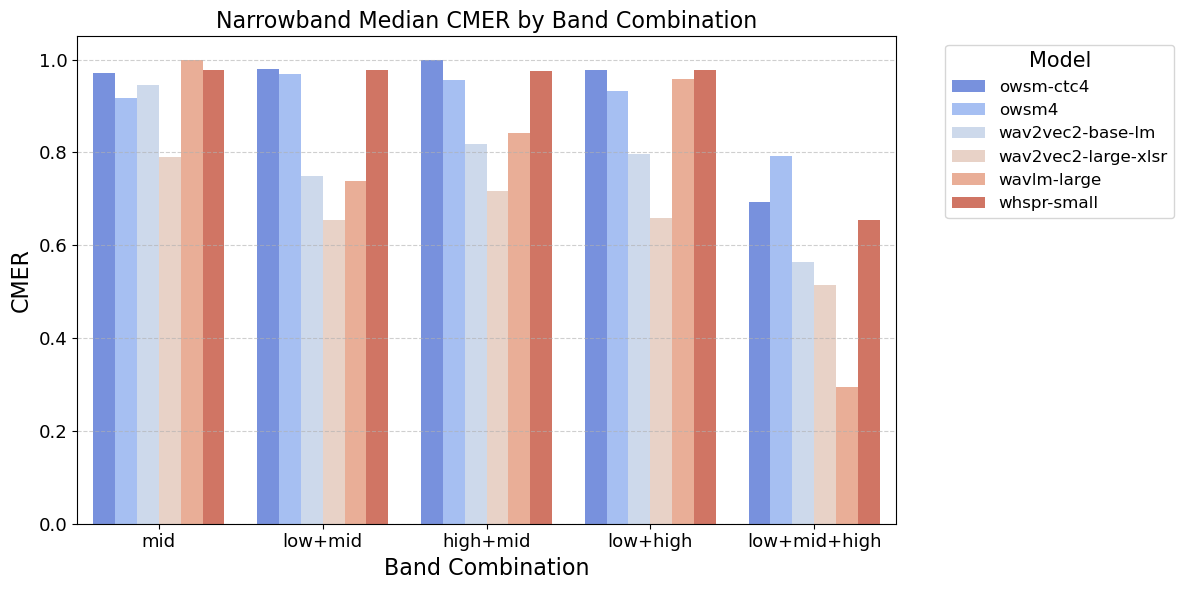

In [131]:
def plot_narrowband_sweep():
    metric_names = ["CER", "CMER"]
    metric_types = ["Overall", "Average", "Median"]
    modes = ["bandwidth", "band_combination"]

    for metric_name in metric_names:
        for metric_type in metric_types:
            for mode in modes:
                # Define paths
                csv_path = f"table_results/narrowband_{metric_type.lower()}_{metric_name}_summary.csv"
                save_path = f"picture_results/adjusted_distortion_picture_results/Narrowband {metric_type} {metric_name} by {mode.capitalize()}.png"

                # Title
                if mode == "bandwidth":
                    title = f"Narrowband {metric_type} {metric_name} by Band Width"
                else:  # band_combination
                    title = f"Narrowband {metric_type} {metric_name} by Band Combination"

                # Call plotting function
                plot_narrowband_comparison(
                    csv_path=csv_path,
                    mode=mode,
                    title=title,
                    metric_name=metric_name,
                    save_path=save_path
                )

    print("All narrowband plots generated.")
plot_narrowband_sweep()

Saved plot to picture_results/Narrowband Overall CER by Band Width.png


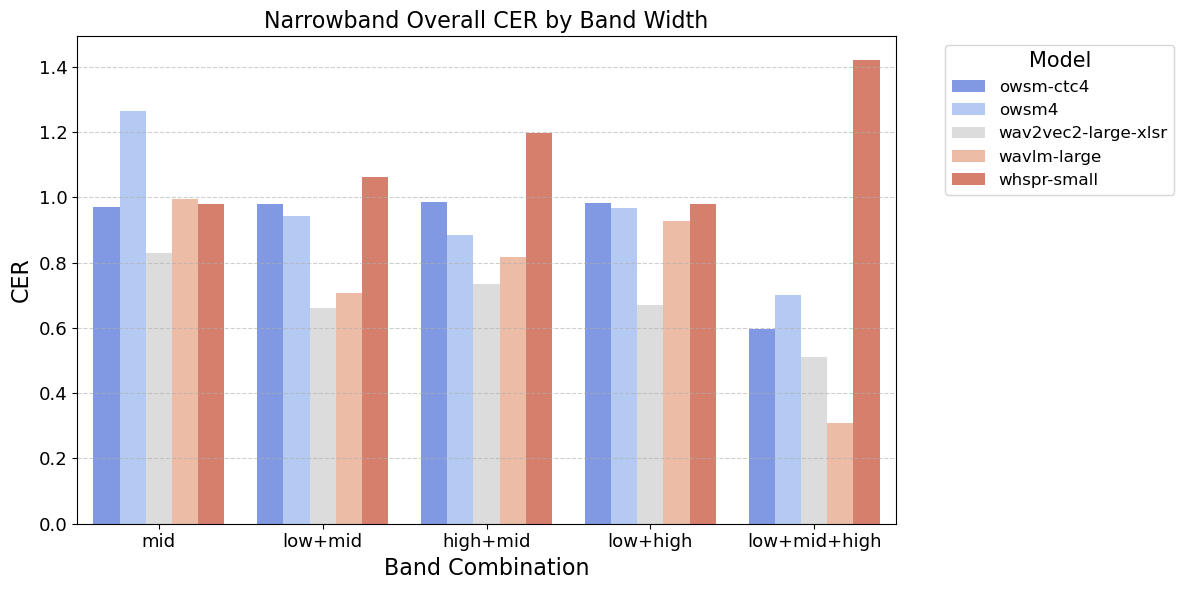

In [ ]:
metric_name="CER"
metric_type="Overall"
mode="band_combination"
plot_narrowband_comparison(
    csv_path=f"table_results/narrowband_{metric_type.lower()}_{metric_name}_summary.csv",
    mode=mode,
    title=f"Narrowband {metric_type} {metric_name} by Band Width",
    metric_name=metric_name,
    save_path=f"picture_results/Narrowband {metric_type} {metric_name} by Band Width.png"
)

Saved plot to picture_results/Narrowband Overall CER by Band Width.png


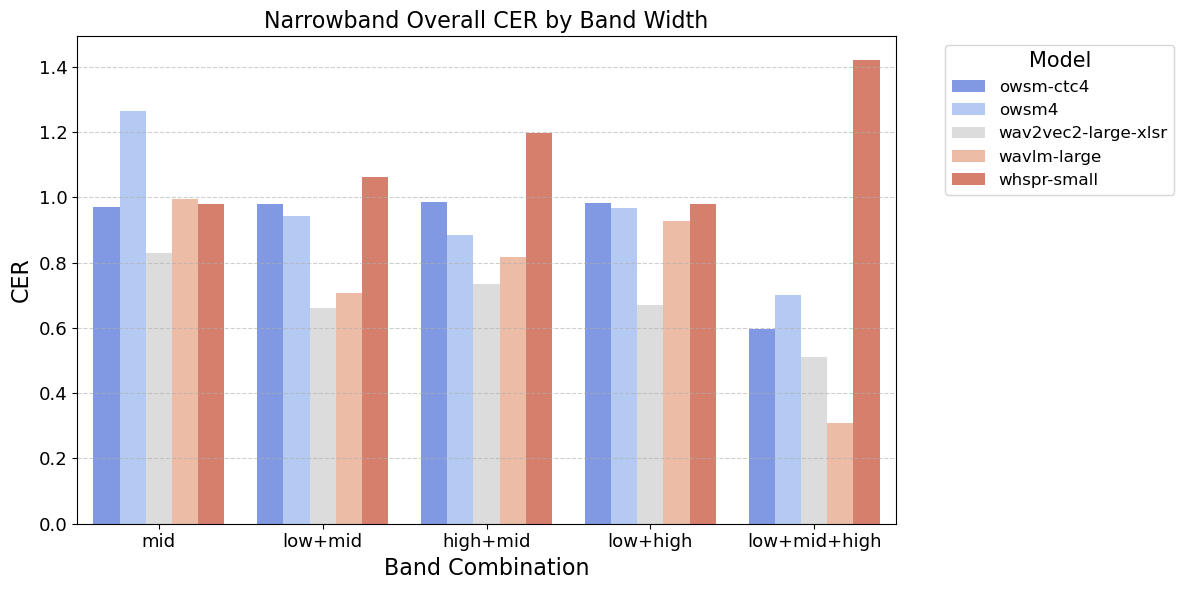

In [112]:
metric_name="CER"
metric_type="Overall"
plot_narrowband_comparison(
    csv_path=f"table_results/narrowband_{metric_type.lower()}_{metric_name}_summary.csv",
    mode="band_combination",
    title=f"Narrowband {metric_type} {metric_name} by Band Width",
    metric_name=metric_name,
    save_path=f"picture_results/Narrowband {metric_type} {metric_name} by Band Width.png"
)

Saved plot to picture_results/Narrowband Overall CMER by Band Width.png


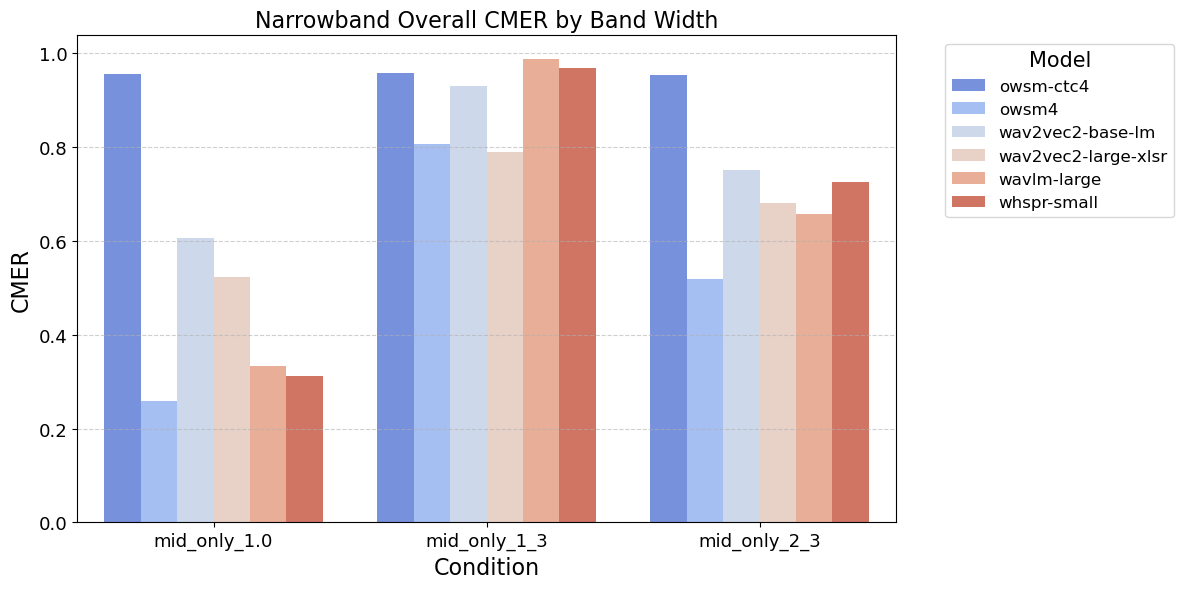

In [110]:
metric_name="CMER"
metric_type="Overall"
plot_narrowband_comparison(
    csv_path=f"table_results/narrowband_{metric_type.lower()}_{metric_name}_summary.csv",
    mode="bandwidth",
    title=f"Narrowband {metric_type} {metric_name} by Band Width",
    metric_name=metric_name,
    save_path=f"picture_results/Narrowband {metric_type} {metric_name} by Band Width.png"
)


# Finetuning comparison

In [ ]:
#
model_name="ft-whspr-small_enc"
ft_area=["narrowband", "narrowband_mid_only_2_3","reversed"]



# Examine Whisper tone-vocoded >1 avg_cer
whisper capped sentence cer but not avg

In [14]:
import numpy as np
with open("cer_res_norm_capped/base_comparison/whspr-small_tone_vocoded_results_cer.json") as file:
    data = json.load(file)

cer_list=[]
for seg in data.get("segments", []):
    cer_list.append(seg.get("cer"))
    if seg.get("cer") >= 1: # there is no larger than 1, so capping worked
        print(seg.get("cer"))
        print("ref: ",seg.get("reference"))
        print("pre: ",seg.get("prediction"))

np.mean(cer_list)

1.0
ref:  but it hadn't
pre:  you
1.0
ref:  and then there is a remembering self
pre:  you
1.0
ref:  approaches in asking the question
pre:  bupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupupup

np.float64(0.9220993939393941)

In [18]:
import numpy as np
with open("cer_res_norm_capped/base_comparison/whspr-small_sculpted_results_cer.json") as file:
    data = json.load(file)

cer_list=[]
for seg in data.get("segments", []):
    cer_list.append(min(seg.get("cer"),1.0))
    if seg.get("cer") > 1: # there is larger than 1, so capping not applied to sentence
        print(seg.get("cer"))
        print("ref: ",seg.get("reference"))
        print("pre: ",seg.get("prediction"))

np.mean(cer_list)

12.445544554455445
ref:  i had somebody count the number of books with happiness in the title published in the last five years
pre:  i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm so glad you're here i'm

np.float64(0.7173069914581954)